#  Hyperparameter Tunning of Gradient Boosted Tree Model
Based on our initial assessment of model families, it appears as though the ensemble techinques of decisions trees tends to significantly outperform all other models. In this section I am going to dive deeper into two of the ensemble techniques. Random Forest and Gradient Boosted Trees. We are going to use this notebook to accomplish multiple tasks.

## Tasks
1) Hyperparameter test using Grid Search Cross Validation to try and get better performance out of these ensemble techniques. (It could be that the baseline hyperparameters are already optimized but we will confirm this)
2) Perform feature importance analysis using the decision tree (Mean-Decrease Impurity) to potentially improve our model
3) Perform Ablation analysis to show decrease in performance when removing specific features  
4) Conduct a failure analysis as to why certain companies perform poorly in our model (hypothesis are welcome)

## Import Libraries
Let's start as we usually do by importing the libraries we will be using in this section.

In [2]:
# Data Manipulation libraries
import numpy as np
import pandas as pd

# Additional libraries
import shap

# Sci-Kit Learn Processing and Evaluating
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, ParameterGrid,learning_curve,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score

# Supervised Learning Models  
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import GradientBoostingRegressor

# Visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns
import altair as alt

# Let's set our Random State and k_folds here as well
random_state = 42
k_fold = 10

c:\Users\tmacp\anaconda3\envs\milestoneII\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data
Okay, now that we are working on our true model we are going to import training and test data so that we can see how we do.

In [3]:
root_path = '../../datasets/'
X_train_file = 'X_train_filled_KPIs_QoQ_PCA.csv'
y_train_file = 'y_train.csv'
X_test_file = 'X_test_filled_KPIs_QoQ_PCA.csv'
y_test_file = 'y_test.csv'
X_tr = pd.read_csv(root_path+X_train_file)
y_tr = pd.read_csv(root_path+y_train_file)
X_te = pd.read_csv(root_path+X_test_file)
y_te = pd.read_csv(root_path+y_test_file)
print(X_tr.shape, y_tr.shape,X_te.shape,y_te.shape)


(1910, 326) (1974, 19) (479, 326) (494, 19)


Once, again, we are dealing with these issues of abnormal numbers between the two datasets because we dropped data from the X_train and X_test file without addressing them in the y_files. So, let's go through and qualize both of these like we did in the previous notebooks.

In [4]:
in_train = set(X_tr['Ticker'])
in_test = set(X_te['Ticker'])
y_tr = y_tr[y_tr['Ticker'].isin(in_train)].copy()
y_te = y_te[y_te['Ticker'].isin(in_test)].copy()
print(f"length of in_train set: {len(in_train)}; length of in_test set: {len(in_test)}")
print(y_tr.shape,y_te.shape)

length of in_train set: 1910; length of in_test set: 479
(1910, 19) (479, 19)


In [5]:
y_tr = y_tr[['Ticker','Revenue_2025Q2','NetIncome_2025Q2']]
y_te = y_te[['Ticker','Revenue_2025Q2','NetIncome_2025Q2']]
print(y_tr.shape,y_te.shape)
y_tr.dropna(inplace=True)
y_te.dropna(inplace=True)
print(y_tr.shape,y_te.shape)
iny_tr = set(y_tr['Ticker'])
iny_te = set(y_te['Ticker'])
X_tr = X_tr[X_tr['Ticker'].isin(iny_tr)].copy()
X_te = X_te[X_te['Ticker'].isin(iny_te)].copy()
print(X_tr.shape, X_te.shape)
print(y_tr.shape, y_te.shape)

(1910, 3) (479, 3)
(1388, 3) (344, 3)
(1388, 326) (344, 326)
(1388, 3) (344, 3)


Okay, we have now equated the two. Let's make sure they are both in the right order as well.

In [6]:
print(X_tr['Ticker'].head(20))
print(y_tr['Ticker'].head(20))

1     HONE
3     RBRK
4      CSL
5      BMI
8     BLKB
9     PARR
11     CNH
12     XEL
14     NSA
15     AIZ
16     DKS
17     PEG
18      CI
19      FG
20    STRA
21      MP
23    ADCT
25     PFE
26    APPN
27     WSR
Name: Ticker, dtype: object
1     HONE
3     RBRK
5      CSL
6      BMI
11    BLKB
12    PARR
15     CNH
16     XEL
18     NSA
19     AIZ
21     DKS
22     PEG
23      CI
24      FG
25    STRA
26      MP
28    ADCT
30     PFE
31    APPN
32     WSR
Name: Ticker, dtype: object


## Hyperparameter Tuning
Alright, now that we have all of our data imported and ready to go, it's time to setup the GridSearchCV in order to tune our hyper parameters. This is going to be slightly dependent on which model we are using so let's set up a different one for each the Random Forest (RF) and Gradient Boosting Trees (GBT). Interestingly, because Tree's don't need scaling, I am going to avoid much of the transformations that we did in the earlier notebook to see how we do on raw values. 

Random Forest Hyperparameters:
- n_estimators  
- max_depth  
- min_samples_leaf  
- min_samples_split  
- max_features  
- bootstrap  
- max_samples

Gradient Boosting Hyperparameters:  
- learning_rate  
- n_estimators  
- max_depth  
- min_samples_leaf  
- min_samples_split  
- max_features  
- subsample  
- loss  
- validation_fraction  
- n_iter_no_change  
- tol

## Hyperparameter Tuning Pipeline
Okay, now that we have defined all of that we can set up our pipeline to run through the hyperparameter tuning for us and see what is best. First, lets drop the name and ticker column as they won't provide anything useful in our datasets.

In [7]:
# Drop the ticker and name columns so we don't explode the feature space unneccesarily
X_tr.drop(columns=['Ticker','Name'],axis=1,inplace=True)
X_te.drop(columns=['Ticker','Name'],axis=1,inplace=True)

In [8]:
## identify categorical columns using dtypes
#cat_cols = [c for c in X_tr.columns if str(X_tr[c].dtype) in ("object", "category")]
#pre = ColumnTransformer(
#    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
#    remainder="passthrough",
#)
#
## base pipeline for gridsearch
#pipe = Pipeline([("pre", pre),
#                 ("model", RandomForestRegressor(random_state=random_state, n_jobs=-1))])
#
## Have a couple of different scorers for analyzing
#def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)
#rmse_s = make_scorer(rmse, greater_is_better=False)
#mae_s  = make_scorer(mean_absolute_error, greater_is_better=False)
#
#scoring = {"rmse": rmse_s, "mae": mae_s, "r2": "r2"}
#cv = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)
#
## Create our grids for the gridsearch (including our two models)
#gbt = GradientBoostingRegressor(random_state=random_state)
#
#gbt_grid = {
#    "model": [gbt],
#    "model__learning_rate": [0.07, 0.1, 0.15],
#    "model__n_estimators": [100, 200, 500],
#    "model__max_depth": [2, 3, 4],
#    "model__min_samples_leaf": [1, 5, 20],
#    "model__min_samples_split": [2, 10, 50],
#    "model__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
#    "model__subsample": [0.6, 0.8, 1.0],
#    "model__loss": ["squared_error", "absolute_error"],
#}
#
## Run the gridsearch and we are going to choose best RMSE
#grid = GridSearchCV(
#    estimator=pipe,
#    param_grid=[gbt_grid],
#    scoring=scoring,
#    refit="r2",          
#    cv=cv,
#    n_jobs=-1,
#    verbose=1,
#    return_train_score=False,
#)
#
#y_series = np.abs(y_tr["Revenue_2025Q2"])
#grid.fit(X_tr, y_series)
#
#print("Best params:", grid.best_params_)
#print(f"Best R2: {grid.best_score_:.3f}")

Alright, now that we have pulled out the Test set parameters: 

Best params: {'model': GradientBoostingRegressor(random_state=42), 'model__learning_rate': 0.15, 'model__loss': 'squared_error', 'model__max_depth': 3, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 50, 'model__n_estimators': 200, 'model__subsample': 1.0}

We can start to get all of the data from it.

In [9]:
# --- data columns ---
cat_cols = ['Sector', 'Exchange', 'Market Cap']

# y_tr_col/y_te_col are your revenue targets, e.g. 'Revenue_2025Q2'
y_tr_series = np.abs(y_tr['Revenue_2025Q2'])
y_te_series = np.abs(y_te['Revenue_2025Q2'])

# --- preproc ---
pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough",
)

# --- tuned model ---
gbr = GradientBoostingRegressor(
    random_state=random_state,
    learning_rate=0.15,
    loss="squared_error",
    max_depth=3,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=50,
    n_estimators=200,
    subsample=1.0,
)

pipe = Pipeline([("pre", pre), ("model", gbr)])

# 
cv = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)



scores = cross_validate(
    pipe, X_tr, y_tr_series, cv=cv, n_jobs=-1, return_train_score=False,
    scoring={"rmse": "neg_root_mean_squared_error",
             "mae":  "neg_mean_absolute_error",
             "r2":   "r2"},
    error_score="raise"   # surface any hidden exceptions
)
rmse_cv = -scores["test_rmse"]
mae_cv  = -scores["test_mae"]
r2_cv   =  scores["test_r2"]

cv_summary = pd.DataFrame({
    "metric": ["RMSE","MAE","R2"],
    "mean":   [np.round(rmse_cv.mean(),2), np.round(mae_cv.mean(),2), r2_cv.mean()],
    "std":    [rmse_cv.std(ddof=1), mae_cv.std(ddof=1), r2_cv.std(ddof=1)],
})

# --- test-set metrics (single numbers) ---
pipe.fit(X_tr, y_tr_series)
y_pred = pipe.predict(X_te)

rmse_test = np.sqrt(mean_squared_error(y_te_series, y_pred))  # RMSE
mae_test  = mean_absolute_error(y_te_series, y_pred)
r2_test   = r2_score(y_te_series, y_pred)

test_summary = pd.Series({"RMSE": rmse_test, "MAE": mae_test, "R2": r2_test})


print("\nTest set:", test_summary.to_dict())
cv_summary




Test set: {'RMSE': 1547342272.9154935, 'MAE': 386593985.2893442, 'R2': 0.9787956495132973}


,metric,mean,std
0,RMSE,1.749359e+09,1.401309e+09
1,MAE,3.779795e+08,1.852431e+08
2,R2,9.665178e-01,2.525271e-02


Alright now, let's calculate success rates for the test set.

In [10]:
def success_rates(y_true, y_pred, thresholds=(0.10, 0.20, 0.40)):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mask = y_true != 0  # avoid div-by-zero; report how many dropped
    rel_err = np.empty_like(y_true, dtype=float)
    rel_err[mask] = np.abs(y_pred[mask] - y_true[mask]) / np.abs(y_true[mask])
    rel_err[~mask] = np.nan

    out = {"n_used": int(mask.sum()), "n_zero_actuals": int((~mask).sum())}
    for t in thresholds:
        out[f"≤{int(t*100)}%"] = np.nanmean(rel_err <= t)
    return pd.Series(out)

# example
rates = success_rates(y_te_series, y_pred)  # after you predict
print(rates)

n_used            344.000000
n_zero_actuals      0.000000
≤10%                0.494186
≤20%                0.750000
≤40%                0.892442
dtype: float64


alright, this is pretty darn good. Let's plot everything to see what it looks like.

In [11]:
# Data
dfp = pd.DataFrame({
    "actual": np.asarray(y_te_series/1_000_000, dtype=float),
    "pred":   np.asarray(y_pred/1_000_000, dtype=float)
})
dfp["resid"] = dfp["actual"] - dfp["pred"]  # residual = y - ŷ

# R² for annotation
r2 = r2_score(dfp["actual"], dfp["pred"])

# ---------- Residuals vs Actual ----------
res_scatter = alt.Chart(dfp).mark_circle(opacity=0.4,color='Magenta',size=60).encode(
    x=alt.X("actual:Q", title="Actual ($ Millions)", axis=alt.Axis(grid=False)),
    y=alt.Y("resid:Q",  title="Residual (y - ŷ) ($ Millions)", axis=alt.Axis(grid=False))
).properties(width=400, height=300, title="Residuals vs Actual")

zero_line = alt.Chart(pd.DataFrame({"y":[0]})).mark_rule().encode(y="y:Q")

residuals_chart = res_scatter + zero_line

# ---------- Predicted vs Actual with 45° line + R² ----------
xy_min = float(min(dfp["actual"].min(), dfp["pred"].min()))
xy_max = float(max(dfp["actual"].max(), dfp["pred"].max()))
diag_df = pd.DataFrame({"x":[xy_min, xy_max], "y":[xy_min, xy_max]})

scatter_xy = alt.Chart(dfp).mark_circle(opacity=0.4,color='Magenta',size=60).encode(
    x=alt.X("actual:Q", title="Actual ($ Millions)", axis=alt.Axis(grid=False)),
    y=alt.Y("pred:Q",   title="Predicted (ŷ) ($ Millions)", axis=alt.Axis(grid=False))
).properties(width=400, height=300, title="Predicted vs Actual")

diag = alt.Chart(diag_df).mark_line(color='black').encode(x="x:Q", y="y:Q")


pred_vs_actual_chart = scatter_xy + diag 

(pred_vs_actual_chart | residuals_chart).configure_view(stroke=None).properties(title=alt.TitleParams(
    'Predicted versus Actual quarterly Revenue for 2025Q2',
    anchor='middle', fontSize=20, fontWeight='bold'
))

alt.HConcatChart(...)

# Failure/Error Analysis
Let's pull out three companies where the success_rate is below 50%. This will allow us to do an indepth look at the companies and hypothesize as to why these companies performed poorly with our model.

Let's start by combining our X_test data with the y_actual and y_pred data.

In [29]:
# Start by merging the dataframes
combined = X_te.copy()
print(len(combined))
combined['y_actual'] = np.abs(y_te['Revenue_2025Q2'])
combined['y_pred'] = y_pred  # scale to millions
combined['resid'] = combined['y_actual'] - combined['y_pred']
combined['Ticker'] = y_te['Ticker'].values  # add Ticker for reference
combined["rel_resid"] = combined["resid"] / combined["y_actual"].replace(0, np.nan)
combined["abs_rel_resid"] = combined["rel_resid"].abs()

# worst misses first
worst = combined.sort_values("abs_rel_resid", ascending=False)
print(worst.iloc[:,-6:].head(4))
print('----------')
print(worst.iloc[:,-6:].tail(4))

344
       y_actual        y_pred         resid Ticker     rel_resid  \
401     75000.0  1.204961e+09 -1.204886e+09   TNET -16065.140677   
341   1313000.0  3.253539e+09 -3.252226e+09    WLK  -2476.943109   
178   7554000.0  3.734719e+09 -3.727165e+09    GLW   -493.402786   
292  26195000.0  1.060792e+10 -1.058172e+10    TMO   -403.959617   

     abs_rel_resid  
401   16065.140677  
341    2476.943109  
178     493.402786  
292     403.959617  
----------
     y_actual        y_pred  resid Ticker  rel_resid  abs_rel_resid
460       NaN  6.248528e+08    NaN   PLAY        NaN            NaN
462       NaN  3.545855e+08    NaN    OHI        NaN            NaN
464       NaN  6.660216e+08    NaN   MPWR        NaN            NaN
471       NaN  1.027472e+09    NaN   HUBG        NaN            NaN


In [30]:
len(worst[worst['Exchange']=='NASDAQ'])

132

Let's try using one of the recommended resources like SHAP found at: https://shap.readthedocs.io/


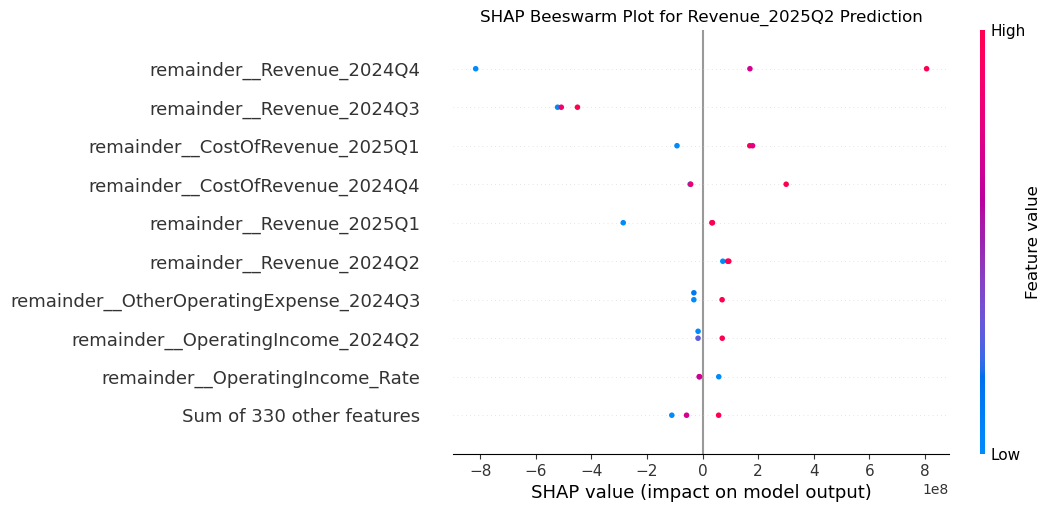

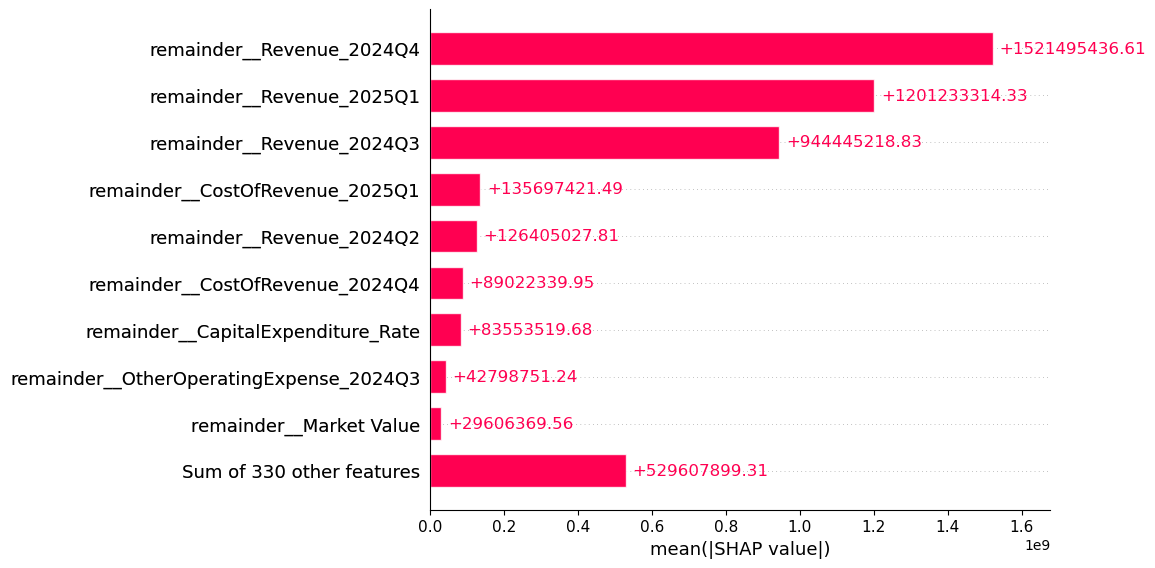

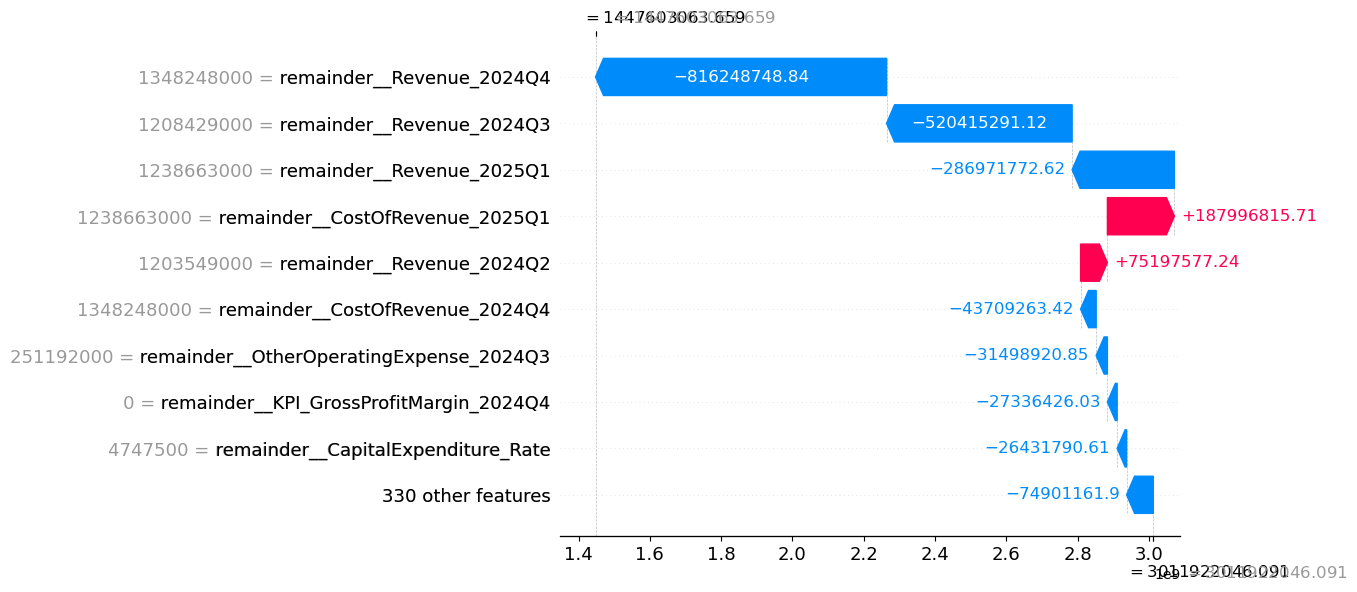

In [ ]:
# 0) fit the pipeline
pipe.fit(X_tr, y_tr_series)

# 1) grab fitted pieces
pre = pipe.named_steps["pre"]          # now fitted
gbr = pipe.named_steps["model"]

# 2) background and test transforms
bg_X  = X_tr.sample(min(1000, len(X_tr)), random_state=random_state)
bg_t  = pre.transform(bg_X)
X_te_t = pre.transform(X_te)

# 3) make dense if needed
import scipy.sparse as sp
if sp.issparse(bg_t):   bg_t   = bg_t.toarray()
if sp.issparse(X_te_t): X_te_t = X_te_t.toarray()

# 4) SHAP
explainer = shap.TreeExplainer(gbr)
sv = explainer(X_te_t, check_additivity=False)
sv.feature_names = pre.get_feature_names_out()
# 3) Feature names after one-hot + passthrough
feat_names = pre.get_feature_names_out()

# 4) Tree explainer on the sklearn GradientBoostingRegressor
explainer = shap.TreeExplainer(gbr)
sv = explainer(X_te_t, check_additivity=False)  # disable additivity check for sklearn GBRT

#Let's plot the beeswar for our particular instances
# 5) Plots
labels = [401, 341, 178]    # DataFrame index labels
idx = X_te.index.get_indexer(labels)

sv.feature_names = feat_names
plt.title("SHAP Beeswarm Plot for Three Selected Firms")
shap.plots.beeswarm(sv[idx], max_display=10)
shap.plots.bar(sv, max_display=10)

# 6) Local explanation for row i
i = 0
shap.plots.waterfall(sv[i])

# Feature Importance
Let's see if we can get some feature importances out of here:

In [14]:
def feature_names_from_pipe(pipe, cat_cols, num_cols):
    pre = pipe.named_steps["pre"]
    ohe = pre.named_transformers_["cat"]
    ohe_names = ohe.get_feature_names_out(cat_cols)
    return list(ohe_names) + list(num_cols)
feat_names = feature_names_from_pipe(pipe, cat_cols, [c for c in X_tr.columns if c not in cat_cols])

gbr = pipe.named_steps["model"]
imp = pd.DataFrame({
    "feature": feat_names,
    "importance": gbr.feature_importances_
}).sort_values("importance", ascending=False)

top = imp.head(10)
alt.Chart(top).mark_bar(color='black',opacity=0.4).encode(
    x=alt.X("importance:Q", title="Gain",axis=alt.Axis(grid=False)),
    y=alt.Y("feature:N", sort="-x", title="Feature",axis=alt.Axis(grid=False))
).properties(width=350, height=20*len(top), title="GBR feature importance").configure_view(stroke=None)

alt.Chart(...)

Now, we need try some feature ablation here. We really want to see what makes this model work. Obviously, we will want to try removing last quarters revenue. Then we we will want to remove all revenue. Then maybe a couple more feature removals. The first thing is to identify the columns that we want to be 'ablaiting'.

In [15]:
top_list = list(top['feature'])


In [16]:
y_series = y_tr['Revenue_2025Q2']

# datasets
datasets = [
    ("X_tot", X_tr.copy()),
    ("X_no_rev", X_tr.drop(columns=['Revenue_2024Q3','Revenue_2024Q4','Revenue_2025Q1','Revenue_2024Q2'])),
    ("X_only_rev", X_tr[['Revenue_2024Q3','Revenue_2024Q4','Revenue_2025Q1','Revenue_2024Q2']]),
    ("X_missing_lead", X_tr.drop(columns=['Revenue_2024Q3'])),
    ("X_missing_lastrev", X_tr.drop(columns=['Revenue_2025Q1'])),
    ("K_best_features", X_tr[top_list])
]


cat_master = ['Sector','Exchange','Market Cap']

def make_pipe(X):
    present_cats = [c for c in cat_master if c in X.columns]
    steps = []
    if present_cats:
        pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), present_cats)],
                                remainder="passthrough")
        steps.append(("pre", pre))
    gbr = GradientBoostingRegressor(
        random_state=random_state, learning_rate=0.15, loss="squared_error",
        max_depth=3, max_features=0.5, min_samples_leaf=1,
        min_samples_split=50, n_estimators=200, subsample=1.0,
    )
    steps.append(("model", gbr))
    return Pipeline(steps)

cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

names = []
rmse_list = []

for name, Xd in datasets:
    pipe = make_pipe(Xd)
    rmse = -cross_val_score(pipe, Xd, y_series,
                            cv=cv, scoring="neg_root_mean_squared_error",
                            n_jobs=-1)
    names.append(name)
    rmse_list.append(rmse)

df = pd.DataFrame({
    "dataset": np.concatenate([[n]*len(v) for n, v in zip(names, rmse_list)]),
    "rmse":    np.concatenate(rmse_list),
})

In [17]:
# summary table
abl_summary = (df.groupby("dataset")["rmse"]
                 .agg(mean="mean", std="std")
                 .sort_values("mean"))
df['rmse'] = df['rmse']/1_000_000  # scale to millions for)
# boxplot
label_map = {
    "X_tot": "All features",
    "X_no_rev": "No revenue",
    "X_only_rev": "Revenue-only",
    "X_missing_lead": "Drop most imporant Revenue",
    "X_missing_lastrev": "Drop most recent Revenue",
    "K_best_features": "Top-10 Features Only"
}

df["xlab"] = df["dataset"].map(label_map).fillna(df["dataset"])
order = [label_map.get(k, k) for k in abl_summary.index]  # preserve your sort

chart = alt.Chart(df).mark_boxplot(size=33, opacity=0.5, median={'color':'black','strokeWidth':3}).encode(
    x=alt.X('xlab:N', sort=order, title='Dataset',
            axis=alt.Axis(labelAngle=45, grid=False)),
    y=alt.Y('rmse:Q', title='CV RMSE ($ Millions)', axis=alt.Axis(grid=False)),
    color=alt.Color('xlab:N', legend=None)
).properties(width=60*len(order), height=320, title='Ablation: 10-fold CV RMSE')

In [18]:
abl_summary

,mean,std
dataset,,
X_only_rev,1.110367e+09,7.127985e+08
K_best_features,1.213771e+09,1.122573e+09
X_tot,1.584163e+09,1.312797e+09
X_missing_lead,1.831951e+09,2.008138e+09
X_missing_lastrev,2.004986e+09,1.905280e+09
X_no_rev,2.448356e+09,2.139122e+09


In [19]:
chart.configure_view(stroke=None).properties(height=600,width=600)

alt.Chart(...)

In [20]:
# encoder dense output for GBR
pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_master)],
    remainder="passthrough",
)

def make_pipe(X):
    present_cats = [c for c in cat_master if c in X.columns]
    steps = []
    if present_cats:
        steps.append(("pre", pre))
    gbr = GradientBoostingRegressor(
        random_state=random_state, learning_rate=0.15, loss="squared_error",
        max_depth=3, max_features=0.5, min_samples_leaf=1,
        min_samples_split=50, n_estimators=200, subsample=1.0,
    )
    steps.append(("model", gbr))
    return Pipeline(steps)

cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

names, r2_list = [], []
for name, Xd in datasets:
    pipe = make_pipe(Xd)
    r2 = cross_val_score(pipe, Xd, y_series, cv=cv, scoring="r2", n_jobs=-1)
    names.append(name)
    r2_list.append(r2)

df = pd.DataFrame({
    "dataset": np.concatenate([[n]*len(v) for n, v in zip(names, r2_list)]),
    "r2":      np.concatenate(r2_list),
})

In [21]:
# summary table (higher is better)
abl_summary = (df.groupby("dataset")["r2"]
                 .agg(mean="mean", std="std")
                 .sort_values("mean", ascending=False))

# labels
label_map = {
    "X_tot": "All features",
    "X_no_rev": "No revenue",
    "X_only_rev": "Revenue-only",
    "X_missing_lead": "Drop most important Revenue",
    "X_missing_lastrev": "Drop most recent Revenue",
    "K_best_features": "Top-10 Features Only"
}

df["xlab"] = df["dataset"].map(label_map).fillna(df["dataset"])
order = [label_map.get(k, k) for k in abl_summary.index]

# boxplot
chart2 = alt.Chart(df).mark_boxplot(size=33, opacity=0.5,
                                   median={'color':'black','strokeWidth':3}).encode(
    x=alt.X('xlab:N', sort=order, title='Dataset',
            axis=alt.Axis(labelAngle=45, grid=False)),
    y=alt.Y('r2:Q', title='CV R²',
            scale=alt.Scale(domain=[0.65, 1], nice=False, clamp=True),
            axis=alt.Axis(grid=False)),
    color=alt.Color('xlab:N', legend=None)
).properties(width=60*len(order), height=320,
             title='Ablation: 10-fold CV R²')

In [22]:
abl_summary

,mean,std
dataset,,
X_only_rev,0.981773,0.009481
K_best_features,0.980005,0.021512
X_tot,0.970818,0.024500
X_missing_lead,0.960001,0.060679
X_missing_lastrev,0.955701,0.050215
X_no_rev,0.920484,0.093707


In [23]:
(chart2 | chart).configure_view(stroke=None).properties(title=alt.TitleParams(
    'Ablation Analysis to Evaluate Feature Importance',
    anchor='middle', fontSize=20, fontWeight='bold'
))

alt.HConcatChart(...)

## Sensitivity Analysis
This is probably the most computationally expensive part so I want to try and do this sooner than later. Let's try it now.

In [24]:
# --- data and columns ---
cat_cols = ['Sector','Exchange','Market Cap']
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)  # faster than 10-fold for sweeps

# --- pipeline with feature reduction (post-OHE) ---
pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
                        remainder="passthrough")
fs  = SelectKBest(score_func=mutual_info_regression, k=200)  # adjust k per speed
base = GradientBoostingRegressor(
    random_state=random_state, loss="squared_error",
    max_depth=3, max_features=0.5, min_samples_leaf=1, min_samples_split=50, subsample=1.0
)
pipe = Pipeline([("pre", pre), ("fs", fs), ("model", base)])

# --- hyperparameter sweep (example: learning_rate vs n_estimators) ---
grid = ParameterGrid({
    "model__learning_rate": [0.01, 0.05, 0.10, 0.2, 0.30, 0.4, 0.5 ,0.6, 0.7, 0.80, 1.20],
    "model__n_estimators":  [10, 100, 200, 300, 400, 600, 800, 1000]
})

rows = []
for p in grid:
    pipe.set_params(**p)
    r2 = cross_val_score(pipe, X_tr, y_tr['Revenue_2025Q2'],
                         cv=cv, scoring="r2", n_jobs=-1).mean()
    rows.append({**p, "r2": r2})   # <- store as r2

df = pd.DataFrame(rows)

Xv = sorted(df["model__learning_rate"].unique())
Yv = sorted(df["model__n_estimators"].unique())
Z  = df.pivot(index="model__n_estimators",
              columns="model__learning_rate",
              values="r2").loc[Yv, Xv].to_numpy()

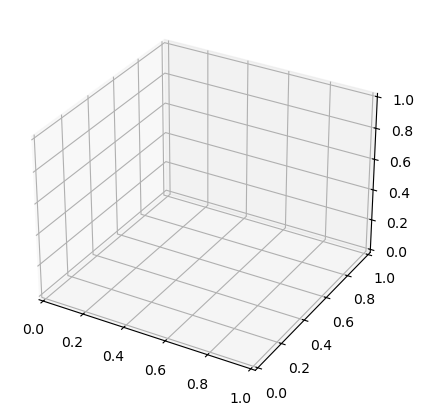

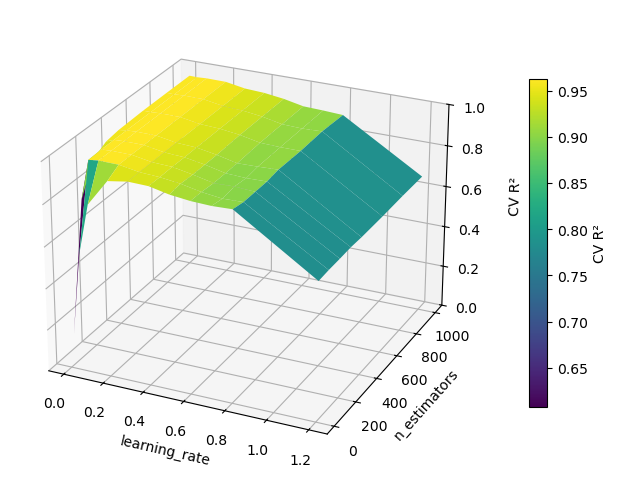

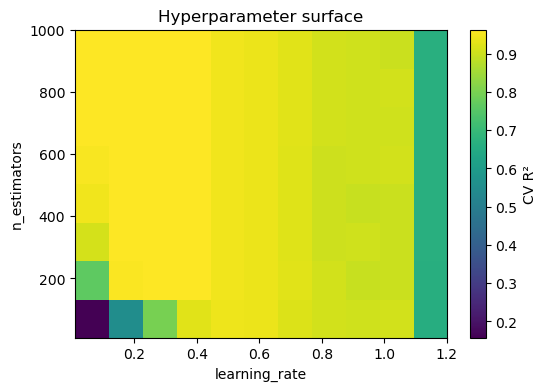

In [25]:
Xg, Yg = np.meshgrid(Xv, Yv)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(Xg, Yg, Z, cmap="viridis", linewidth=0, antialiased=True)

ax.set_xlabel("learning_rate")
ax.set_ylabel("n_estimators")
ax.set_zlim(0,1)
ax.set_zlabel("CV R²", labelpad=12)   # increase if clipped
ax.view_init(elev=25, azim=-65)        # optional

# colorbar keyed to values
cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=18, pad=0.08)
cbar.set_label("CV R²")

# if still clipped, loosen margins
fig.subplots_adjust(right=0.92, bottom=0.1)


# --- 2D heatmap (often clearer) ---
plt.figure(figsize=(6,4))
plt.imshow(Z, aspect="auto", origin="lower",
           extent=[min(Xv), max(Xv), min(Yv), max(Yv)])
plt.colorbar(label="CV R²")
plt.xlabel("learning_rate"); plt.ylabel("n_estimators")
plt.title("Hyperparameter surface")
plt.show()

In [26]:
# --- data and columns ---
cat_cols = ['Sector','Exchange','Market Cap']
cv = KFold(n_splits=5, shuffle=True, random_state=0)  # faster than 10-fold for sweeps

# --- pipeline with feature reduction (post-OHE) ---
pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
                        remainder="passthrough")
fs  = SelectKBest(score_func=mutual_info_regression, k=200)  # adjust k per speed
base = GradientBoostingRegressor(
    random_state=0, loss="squared_error",
    max_depth=3, max_features=0.5, min_samples_leaf=1, min_samples_split=50, subsample=1.0
)
pipe = Pipeline([("pre", pre), ("fs", fs), ("model", base)])

grid = ParameterGrid({
    "model__learning_rate": [0.01, 0.05, 0.10, 0.2, 0.30, 0.4, 0.5 ,0.6, 0.7, 0.80, 1.20],
    "model__n_estimators":  [10, 100, 200, 300, 400, 600, 800, 1000]
})

rows = []
for p in grid:
    pipe.set_params(**p)
    # RMSE (positive)
    rmse = -cross_val_score(pipe, X_tr, y_tr['Revenue_2025Q2'],
                            cv=cv, scoring="neg_root_mean_squared_error",
                            n_jobs=-1).mean()
    rows.append({**p, "rmse": rmse})

df = pd.DataFrame(rows)

# --- 3D surface (matplotlib) ---
Xv = sorted(df["model__learning_rate"].unique())
Yv = sorted(df["model__n_estimators"].unique())
Z = df.pivot(index="model__n_estimators", columns="model__learning_rate", values="rmse").loc[Yv, Xv].to_numpy()


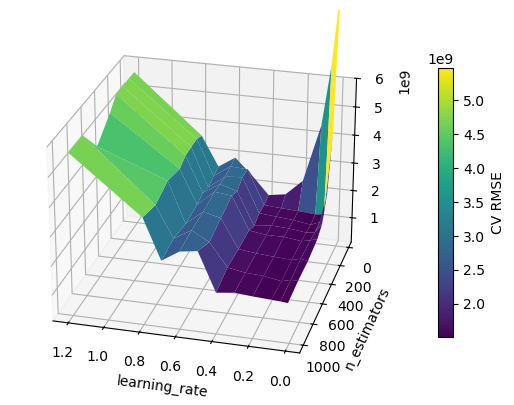

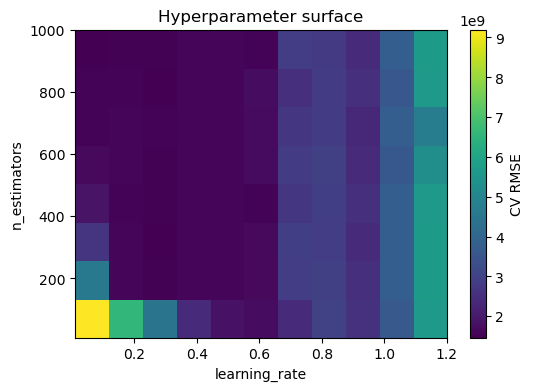

In [27]:
# --- 3D surface (matplotlib) ---
Xv = sorted(df["model__learning_rate"].unique())
Yv = sorted(df["model__n_estimators"].unique())
Z = df.pivot(index="model__n_estimators", columns="model__learning_rate", values="rmse").loc[Yv, Xv].to_numpy()

Xg, Yg = np.meshgrid(Xv, Yv)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Xg, Yg, Z, linewidth=0, cmap='viridis', antialiased=True)
ax.set_zlim(100_000_000, 6_000_000_000) 
ax.view_init(elev=25, azim=105)        # optional
ax.set_xlabel("learning_rate"); ax.set_ylabel("n_estimators"); ax.set_zlabel
("CV RMSE")
# colorbar keyed to values
cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=18, pad=0.08)
cbar.set_label("CV RMSE")
plt.show()

# --- 2D heatmap (often clearer) ---
plt.figure(figsize=(6,4))
plt.imshow(Z, aspect="auto", origin="lower",
           extent=[min(Xv), max(Xv), min(Yv), max(Yv)])
plt.colorbar(label="CV RMSE")
plt.xlabel("learning_rate"); plt.ylabel("n_estimators")
plt.title("Hyperparameter surface")
plt.show()

## Learning Curve
Let's now plot a learning curve to see if we are continually getting improvement with the larger and larger sample size using RMSE. So we are looking for a lower and lower value. 

In [28]:
pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"),
                          ['Sector','Exchange','Market Cap'])],
                        remainder="passthrough")
pipe = Pipeline([("pre", pre), ("model", gbr)])  # gbr from your best params

# sample sizes
train_sizes = [10,50,100,200,400,600,800,1000]

cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

ts, train_scores, test_scores = learning_curve(
    pipe, X_tr, y_tr['Revenue_2025Q2'],
    train_sizes=train_sizes,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    shuffle=True, random_state=0, n_jobs=-1
)

df = pd.DataFrame({
    "n_train": ts,
    "rmse_mean": -test_scores.mean(axis=1)/1_000_000,
    "rmse_std":  test_scores.std(axis=1, ddof=1)/1_000_000
})
df["lo"] = df["rmse_mean"] - df["rmse_std"]
df["hi"] = df["rmse_mean"] + df["rmse_std"]

# Altair line + band
line = alt.Chart(df).mark_line(color='purple').encode(
    x=alt.X("n_train:Q", title="Training samples", axis=alt.Axis(grid=False)),
    y=alt.Y("rmse_mean:Q", title="CV RMSE ($ Millions)",axis=alt.Axis(grid=False))
)
band = alt.Chart(df).mark_area(color = 'purple', opacity=0.25).encode(
    x="n_train:Q", y="lo:Q", y2="hi:Q"
)
pts = alt.Chart(df).mark_point(color='purple').encode(x="n_train:Q", y="rmse_mean:Q")

(band + line + pts).configure_view(stroke=None).properties(height=600,width=600,title='Learning Curve: Root Mean Squared Error with Increasing Training Set Size')

alt.LayerChart(...)